In [34]:
from math import sqrt
from datetime import datetime
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.svm import SVR
plt.style.use('fivethirtyeight')

In [35]:
# Datayı Yükleyelim
path = r'c:\sxk990_6ay.xlsx'
data = pd.read_excel(path, date_parser=[0])
# İlk 5 Satır
data.head()

,DATE_TIME,MAXIMUM_SPEED,MINIMUM_SPEED,AVERAGE_SPEED,NUMBER_OF_VEHICLES
0,2022-01-01 00:00:00,133,1,60,149
1,2022-01-01 01:00:00,133,8,63,130
2,2022-01-01 02:00:00,139,7,69,101
3,2022-01-01 03:00:00,145,3,61,90
4,2022-01-01 04:00:00,148,6,73,55


In [36]:
#Datetime Haline Getirilmesi
data['DATE_TIME'] = pd.to_datetime(data.DATE_TIME, format='%Y-%m-%d %H:%M:%S')
#İndex'e Alınması
data.index = data.DATE_TIME

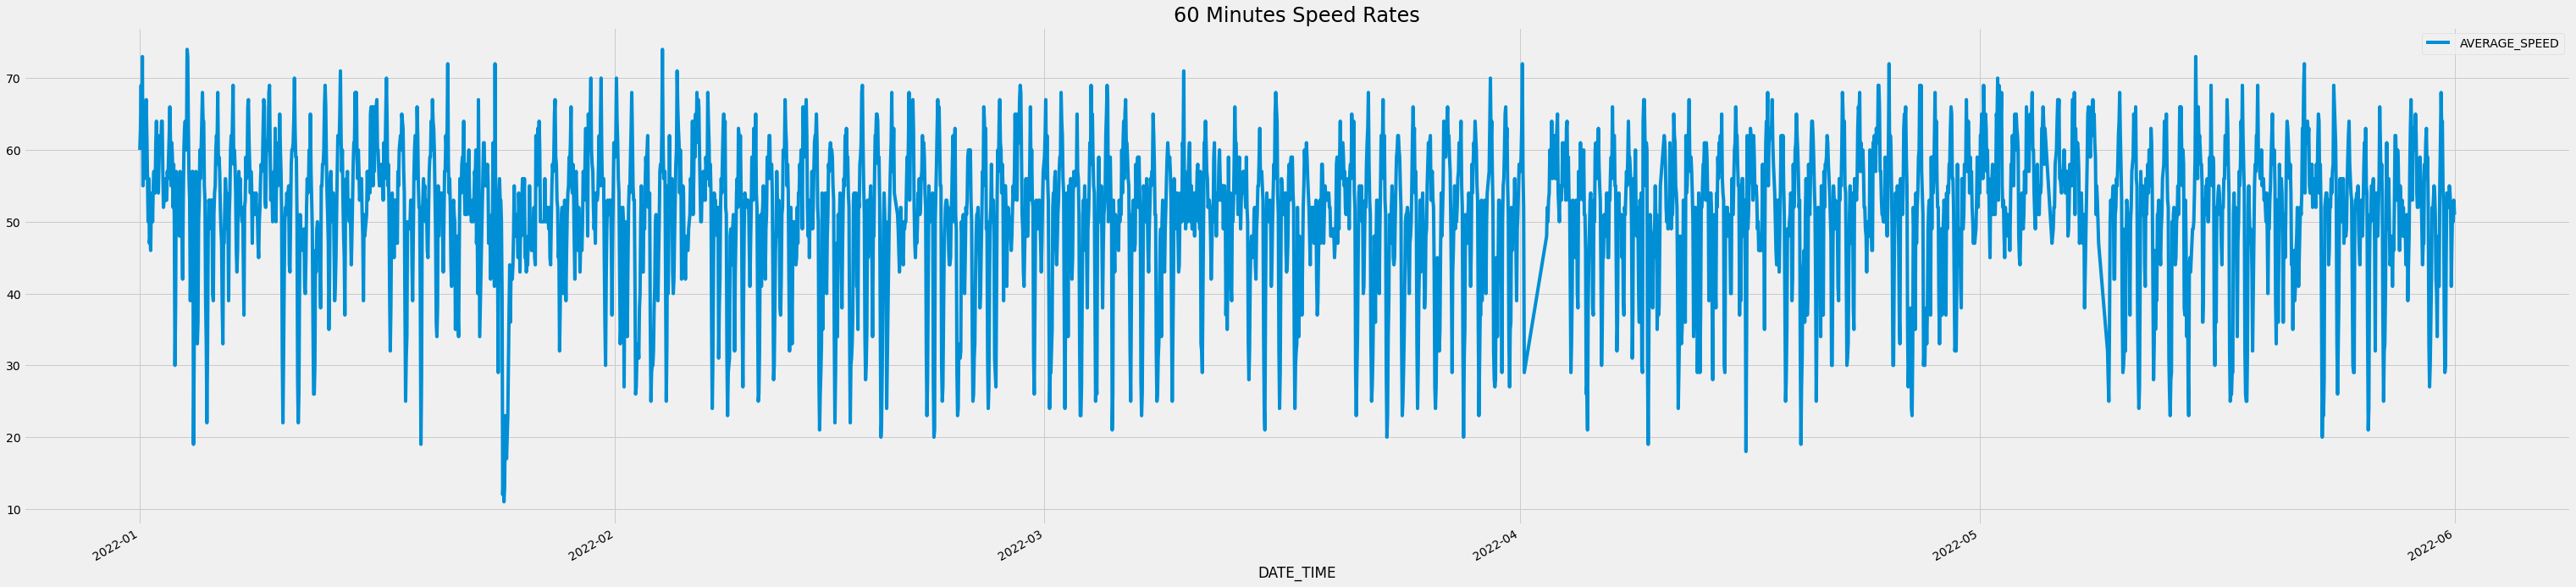

In [37]:
fig = plt.figure(figsize=(48,12))
data.AVERAGE_SPEED.plot(label='AVERAGE_SPEED')
plt.legend(loc='best')
plt.title('60 Minutes Speed Rates', fontsize=24)
plt.show()

In [38]:
train_start_dt = '2022-01-01 00:00:00'
test_start_dt = '2022-04-01 00:00:00'

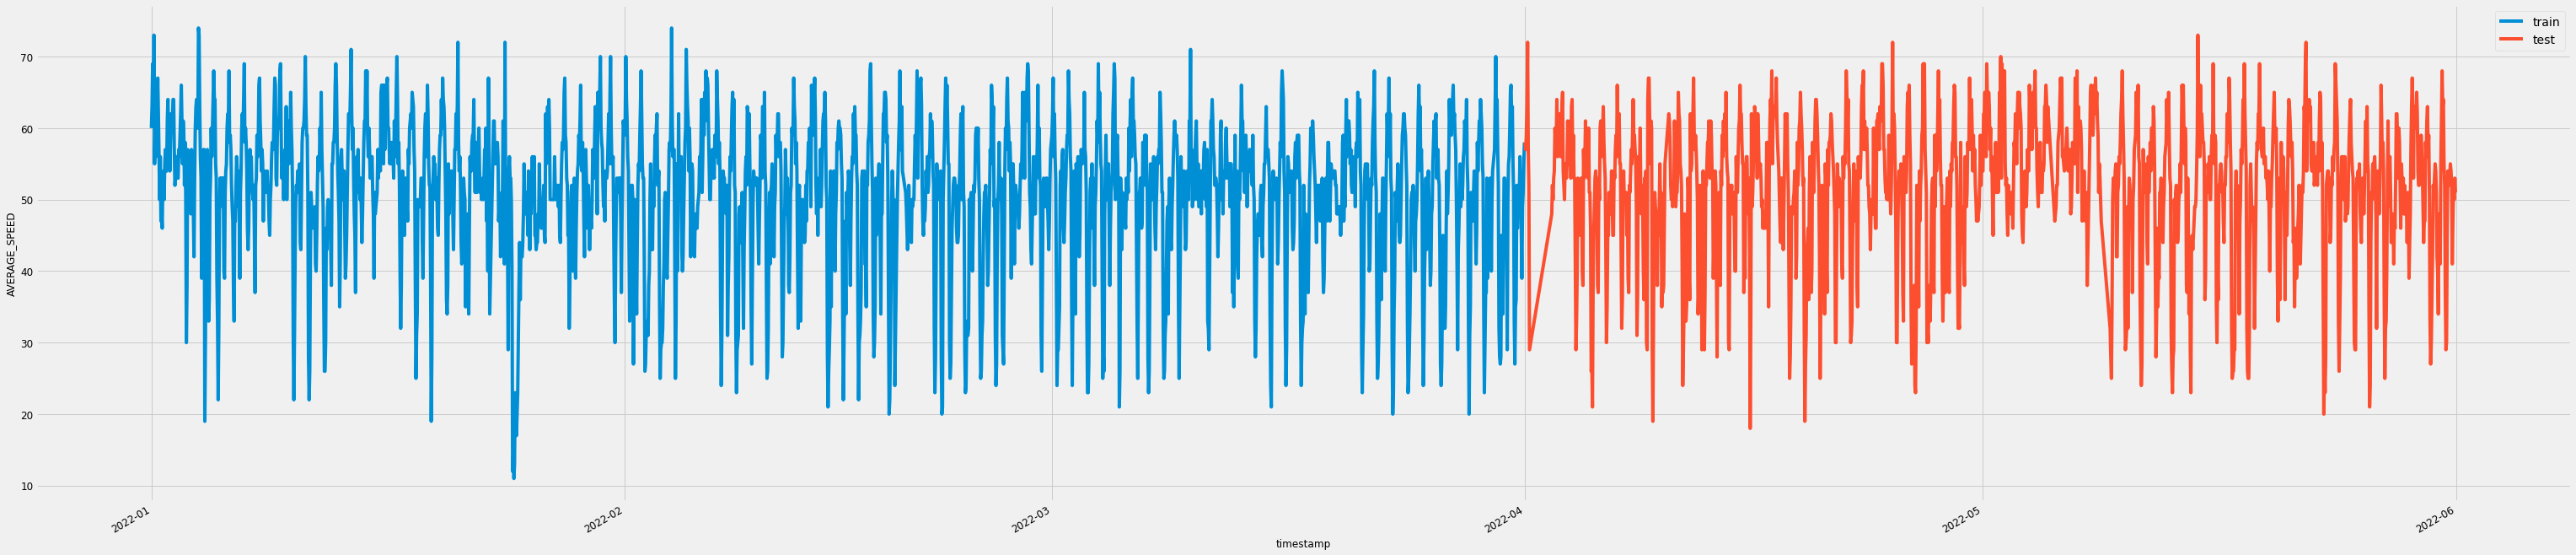

In [39]:
data[(data.index < test_start_dt) & (data.index >= train_start_dt)][['AVERAGE_SPEED']].rename(columns={'AVERAGE_SPEED':'train'}) \
    .join(data[test_start_dt:][['AVERAGE_SPEED']].rename(columns={'AVERAGE_SPEED':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(48, 12), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('AVERAGE_SPEED', fontsize=12)
plt.show()

In [40]:
train = data.copy()[(data.index >= train_start_dt) & (data.index < test_start_dt)][['AVERAGE_SPEED']]
test = data.copy()[data.index >= test_start_dt][['AVERAGE_SPEED']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (2145, 1)
Test data shape:  (1392, 1)


In [41]:
scaler = MinMaxScaler()
train['AVERAGE_SPEED'] = scaler.fit_transform(train)
test['AVERAGE_SPEED'] = scaler.transform(test)

In [42]:
# Converting to numpy arrays
train_data = train.values
test_data = test.values
timesteps=4

In [43]:
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]

In [44]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

In [45]:
print('Training data shape: ', x_train.shape)

Training data shape:  (2142, 3)


In [46]:
model = SVR(kernel='rbf',gamma=0.75, C=10, epsilon = 0.005)
model.fit(x_train, y_train[:,0])
SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.005, gamma=10.05,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

SVR(C=100, epsilon=0.005, gamma=10.05)

In [47]:
model.get_params()

{'C': 10,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.005,
 'gamma': 0.75,
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [48]:
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

In [49]:
# Scaling the predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)
# Scaling the original values
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

In [50]:
train_timestamps = data[(data.index < test_start_dt) & (data.index >= train_start_dt)].index[timesteps-1:]
test_timestamps = data[test_start_dt:].index[timesteps-1:]

In [51]:
score_tr = math.sqrt(mean_squared_error(y_train, y_train_pred))
print("Train data score: %.2f RMSE" % score_tr)
score_t = math.sqrt(mean_squared_error(y_test, y_test_pred))
print("Test data score: %.2f RMSE" % score_t)

Train data score: 6.31 RMSE
Test data score: 6.70 RMSE


In [52]:
from sklearn.metrics import mean_absolute_percentage_error

error_mape_tr = 100*mean_absolute_percentage_error(y_train, y_train_pred)
print("Train data score: %.2f MAPE" % error_mape_tr)

error_mape_t = 100*mean_absolute_percentage_error(y_test, y_test_pred)
print("Test data score: %.2f MAPE" % error_mape_t)

Train data score: 10.36 MAPE
Test data score: 10.74 MAPE


In [53]:
mdape_tr = np.median((np.abs(np.subtract(y_train, y_train_pred)/ y_train))) * 100
print("Train data score: %.2f MdAPE" % mdape_tr)

mdape_t = np.median((np.abs(np.subtract(y_test, y_test_pred)/ y_test))) * 100
print("Test data score: %.2f MdAPE" % mdape_t)

Train data score: 6.57 MdAPE
Test data score: 6.67 MdAPE


In [54]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

error_smape_tr = smape(y_train,y_train_pred)
print("Train data score: %.2f SMAPE" % error_smape_tr)
error_smape_t = smape(y_test,y_test_pred)
print("Test data score: %.2f SMAPE" % np.mean(error_smape_t))

Train data score: 9.77 SMAPE
Test data score: 10.26 SMAPE


In [55]:
from sklearn.metrics import mean_absolute_error
e_tr = y_train - y_train_pred
scale = mean_absolute_error(y_train[1:], y_train[:-1])
mase_tr = np.mean(np.abs(e_tr / scale))
print("Train data score: %.2f MASE" % mase_tr)

e_t = y_test - y_test_pred
scale = mean_absolute_error(y_test[1:], y_test[:-1])
mase_t = np.mean(np.abs(e_t / scale))
print("Test data score: %.2f MASE" % mase_t)

Train data score: 0.86 MASE
Test data score: 0.90 MASE


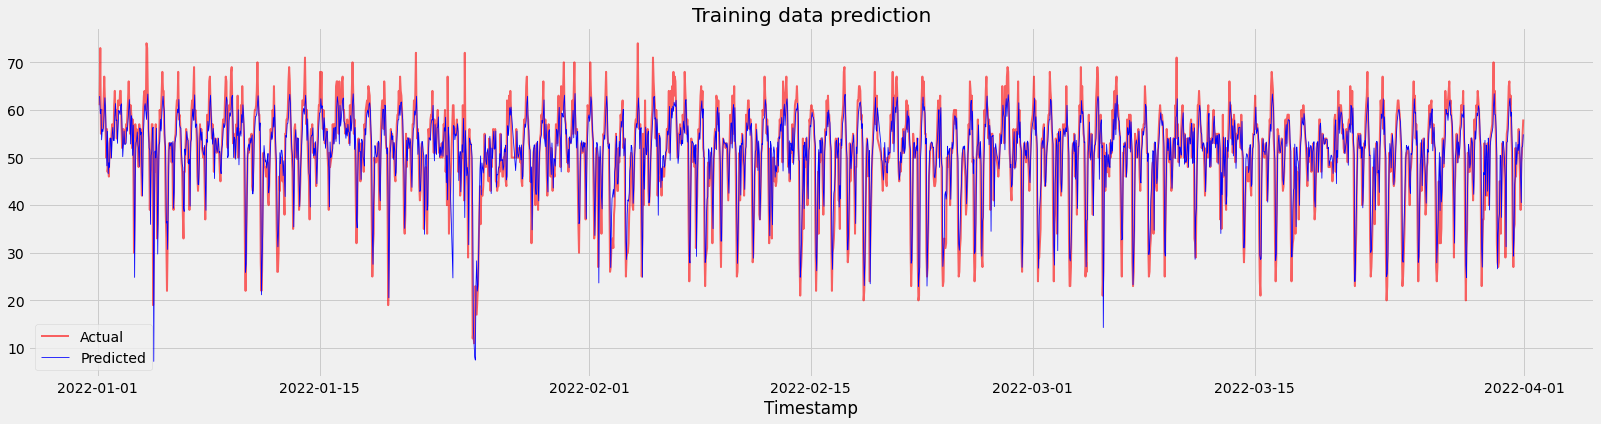

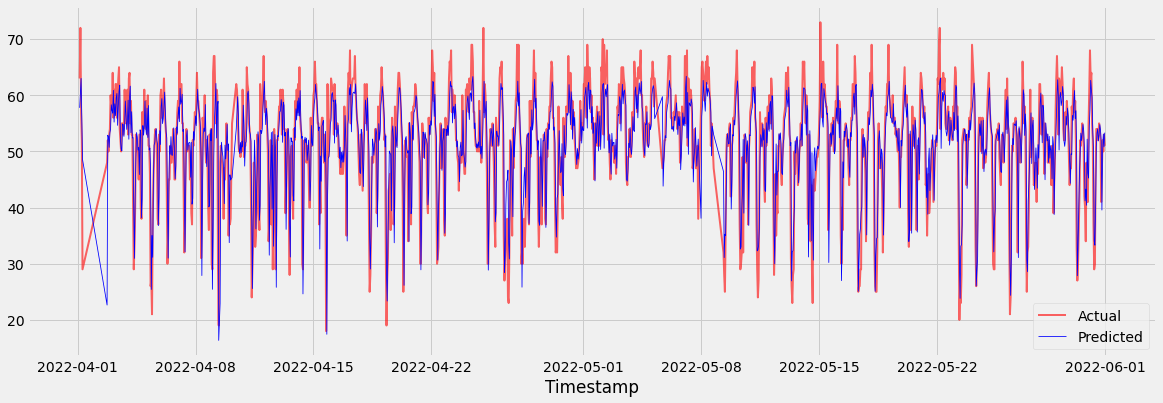

In [56]:
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction")
plt.show()

plt.figure(figsize=(18,6))
plt.plot(test_timestamps, y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.show()

In [57]:
from scipy.stats import f_oneway
f_oneway(y_train[:, 0], y_train_pred[:, 0])

F_onewayResult(statistic=1.2482122055821923, pvalue=0.26395689311516174)

In [58]:
f_oneway(y_test[:, 0], y_test_pred[:, 0])

F_onewayResult(statistic=0.0008078064685546174, pvalue=0.9773276715601045)